# SIIM Covid19 Detection Exploratory Data Analysis

## Importing libraries

In [ ]:
!pip install pydicom --upgrade --quiet

     |████████████████████████████████| 1.9MB 15.6MB/s 


In [ ]:
import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import pydicom # For reading dicom files

## Downloading the data
This is just a 1 time thing. I have downloaded that data and saved in my google drive. The data is of about 83Gb in the zip compressed format.

In [ ]:
# !pip uninstall kaggle -y --quiet
# !pip install kaggle --quiet
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle
# !kaggle competitions download -c siim-covid19-detection
# !unzip /content/siim-covid19-detection.zip -d /content/drive/MyDrive/Projects/SIIM-Covid19/input

## Configuration

In [ ]:
class Config:
  
  INPUT_DIR = '/content/drive/MyDrive/Projects/SIIM-Covid19/input'
  TRAIN_DIR = '/content/drive/MyDrive/Projects/SIIM-Covid19/input/train'
  TRAIN_STUDY_LEVEL = '/content/drive/MyDrive/Projects/SIIM-Covid19/input/train_study_level.csv'
  TRAIN_IMAGE_LEVEL = '/content/drive/MyDrive/Projects/SIIM-Covid19/input/train_image_level.csv'

  SAMPLE_SUBMISSION = '/content/drive/MyDrive/Projects/SIIM-Covid19/input/sample_submission.csv'

In [ ]:
config = Config()

## Looking at the data

In [ ]:
train_folders = glob.glob(config.TRAIN_DIR + '/*')
print('Folders in the train folder: ', len(train_folders))

Folders in the train folder:  6054


The Basic Structure of data

* The data in the train folder is such that you have a folder for each study which contains sub folder by image id which then contains the dicom file of that perticular study and image.
* The total study folders in the train folder are 6054.
* The total number of images found are 6334

In [ ]:
train_study = pd.read_csv(config.TRAIN_STUDY_LEVEL)
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
print('Total no of studies in the train study file: ', train_study['id'].nunique())

Total no of studies in the train study file:  6054


Observations:


*   We have a **id** column which contains that id of the study.
*   The number of ids match the size of the folder as specified above."



In [ ]:
train_image = pd.read_csv(config.TRAIN_IMAGE_LEVEL)
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [ ]:
print('Total no of images in the train image file: ', len(train_image))

Total no of images in the train image file:  6334


Observations: 
* As we can see that the size of **train_image** matches with that of the no. of **StudyInstanceUID** in the **train_study** and hence we will use that to merge these data frames.

In [ ]:
submission_file = pd.read_csv(config.SAMPLE_SUBMISSION)
submission_file.head()

,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1


In [ ]:
submission_file.tail()

,id,PredictionString
2472,46719b856de1_image,none 1 0 0 1 1
2473,31c07523a69a_image,none 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1
2475,ccc5b63ca96d_image,none 1 0 0 1 1
2476,5e8ac1fe2b82_image,none 1 0 0 1 1


### Observations:
* After a very elementary look at the data we can discuss what is our problem in a overview. We have 2 tasks:
  * Given a study_id and all the images contained in it we have to predict a bounding box in case we find some sort of anamoly in the image.
  * Given a image_id we have predict wheather the image have one of the following label or not:
    * Negative for Pneumonia
    * Typical Appearance
    * Indeteminate Appearance
    * Atypical Appearance

## Exploring the **train_study**
There are several images under one study. In the real world if one image is found to be abnormal then the radiologist flag the whole study as abnormal so the point is that in a example study of 5 images there could be a image which is abnormal and the rest of them are normal but all 5 will be labelled as abnormal and hence we will have to be careful of that.

In [ ]:
train_study.head(2)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1


In [ ]:
train_study['None'] = np.sum(train_study.drop(columns='id').values, axis=1) == 0

In [ ]:
train_study[train_study['None'] == True]

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,None


Observations:
* This shows that there is no such study_id in the train set which don't have any of the four labels but it is mentioned in the competition website that a study id can have multiple labels. This gives us 2 approaches:
  * Create a model for each label
    * Advantage - As we predict only one label its essentially becomes binary classification problem.
    * Disadvantage - Computationally expensive.
  * Create a multi-label classification model.
    * Advantage - Computationally less expensive.
    * Disadvantage - As in the training data we don't have multiple labels and hence our model would not have seen any such sample.

* In an attempt to get best of both worlds we will make a branched model such that we will have a back_bone model which gives features from the images and then we will branch those features to different small models.

## Looking at the distribution of labels

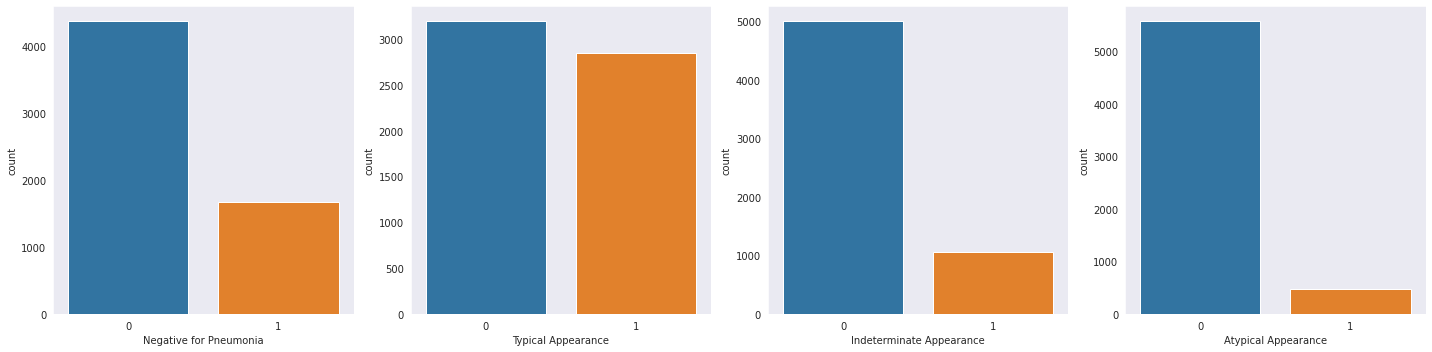

In [ ]:
sns.set_style('dark')

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
sns.countplot(x=train_study['Negative for Pneumonia'])
plt.subplot(1,4,2)
sns.countplot(x=train_study['Typical Appearance'])
plt.subplot(1,4,3)
sns.countplot(x=train_study['Indeterminate Appearance'])
plt.subplot(1,4,4)
sns.countplot(x=train_study['Atypical Appearance'])
plt.tight_layout()

### Observations:
* There is class imbalance in the labels which we will try to handle.
* Also this class imbalance will only increase if take the factor that this imbalance is from study not the images and hence when we go to image lvl the imbalance may increase.

## Making a New Dataframe

In [ ]:
train_study.drop(columns = ['None'], inplace=True)

In [ ]:
train_study['id'] = train_study['id'].map(lambda x: x.split('_')[0])
train_study.columns = ['study_id', 'Negative', 'Typical', 'Intermediate', 'Atypical']

In [ ]:
train_study.head(2)

,study_id,Negative,Typical,Intermediate,Atypical
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1


In [ ]:
image_files = glob.glob(f'{config.TRAIN_DIR}/*/*/*')

In [ ]:
image_files[:3]

['/content/drive/MyDrive/Projects/SIIM-Covid19/input/train/fa6d3b56e333/27ad48d6bd2d/9bc4d429d4e8.dcm',
 '/content/drive/MyDrive/Projects/SIIM-Covid19/input/train/7dbc098b8eaf/21b49419d829/78753bfe52b2.dcm',
 '/content/drive/MyDrive/Projects/SIIM-Covid19/input/train/20a86e21402f/637b252e991f/0811fe666ab0.dcm']

In [ ]:
new_df = pd.DataFrame()
new_df['image_paths'] = image_files
new_df['study_id'] = [i.split('/')[-3] for i in image_files]
new_df.head(2)

,image_paths,study_id
0,/content/drive/MyDrive/Projects/SIIM-Covid19/i...,fa6d3b56e333
1,/content/drive/MyDrive/Projects/SIIM-Covid19/i...,7dbc098b8eaf


In [ ]:
new_df = pd.merge(new_df, train_study, on='study_id')
new_df.head(2)

,image_paths,study_id,Negative,Typical,Intermediate,Atypical
0,/content/drive/MyDrive/Projects/SIIM-Covid19/i...,fa6d3b56e333,0,1,0,0
1,/content/drive/MyDrive/Projects/SIIM-Covid19/i...,7dbc098b8eaf,0,0,1,0


In [ ]:
len(new_df)

6334

In [ ]:
np.sum(new_df.isna())

image_paths     0
study_id        0
Negative        0
Typical         0
Intermediate    0
Atypical        0
dtype: int64

In [ ]:
# verify every path
incorrect_paths = []
all_exists = 1
for i in tqdm(new_df['image_paths']):
  if not os.path.exists(str(i)):
    all_exists = 0
    incorrect_paths.append(i)

if all_exists:
  print("Every path is correct")


Every path is correct


## Looking at some images from classification objective

In [ ]:
def random_display():
  Negative_sample = new_df[new_df['Negative']==1].sample(1)
  Typical_sample = new_df[new_df['Typical']==1].sample(1)
  Intermediate_sample = new_df[new_df['Intermediate']==1].sample(1)
  Atypical_sample = new_df[new_df['Atypical']==1].sample(1)

  samples = [Negative_sample, Typical_sample, Intermediate_sample, Atypical_sample]

  plt.figure(figsize=(20,20))
  for idx, (sample, label) in enumerate(zip(samples, ['negative', 'typical', 'intermediate', 'atypical'])):
    dicom = pydicom.dcmread(sample['image_paths'].values[0])
    image = dicom.pixel_array
    plt.subplot(2,2,idx+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)

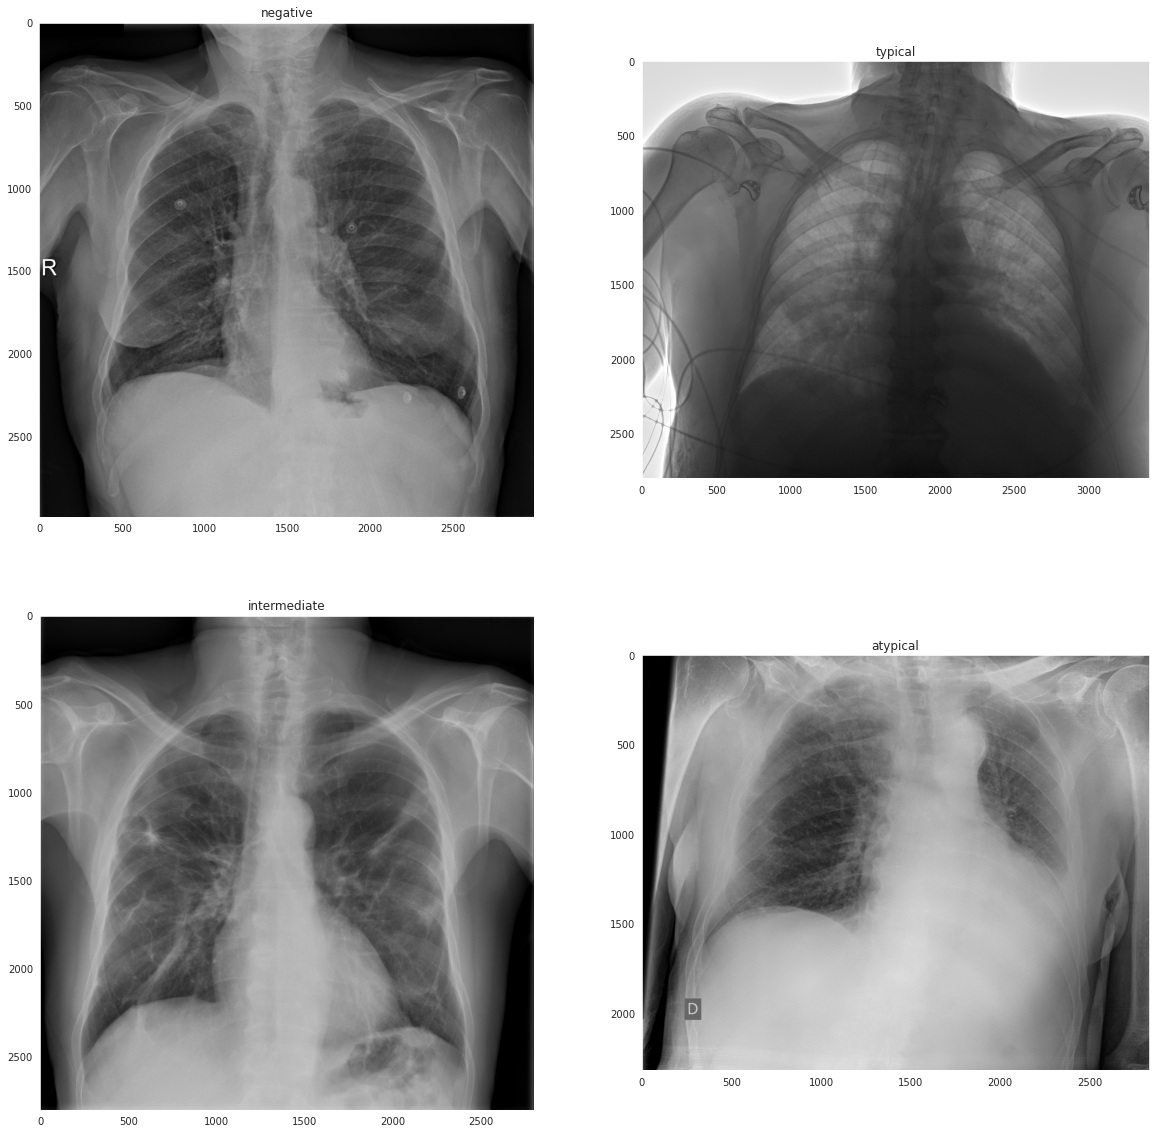

In [ ]:
random_display()

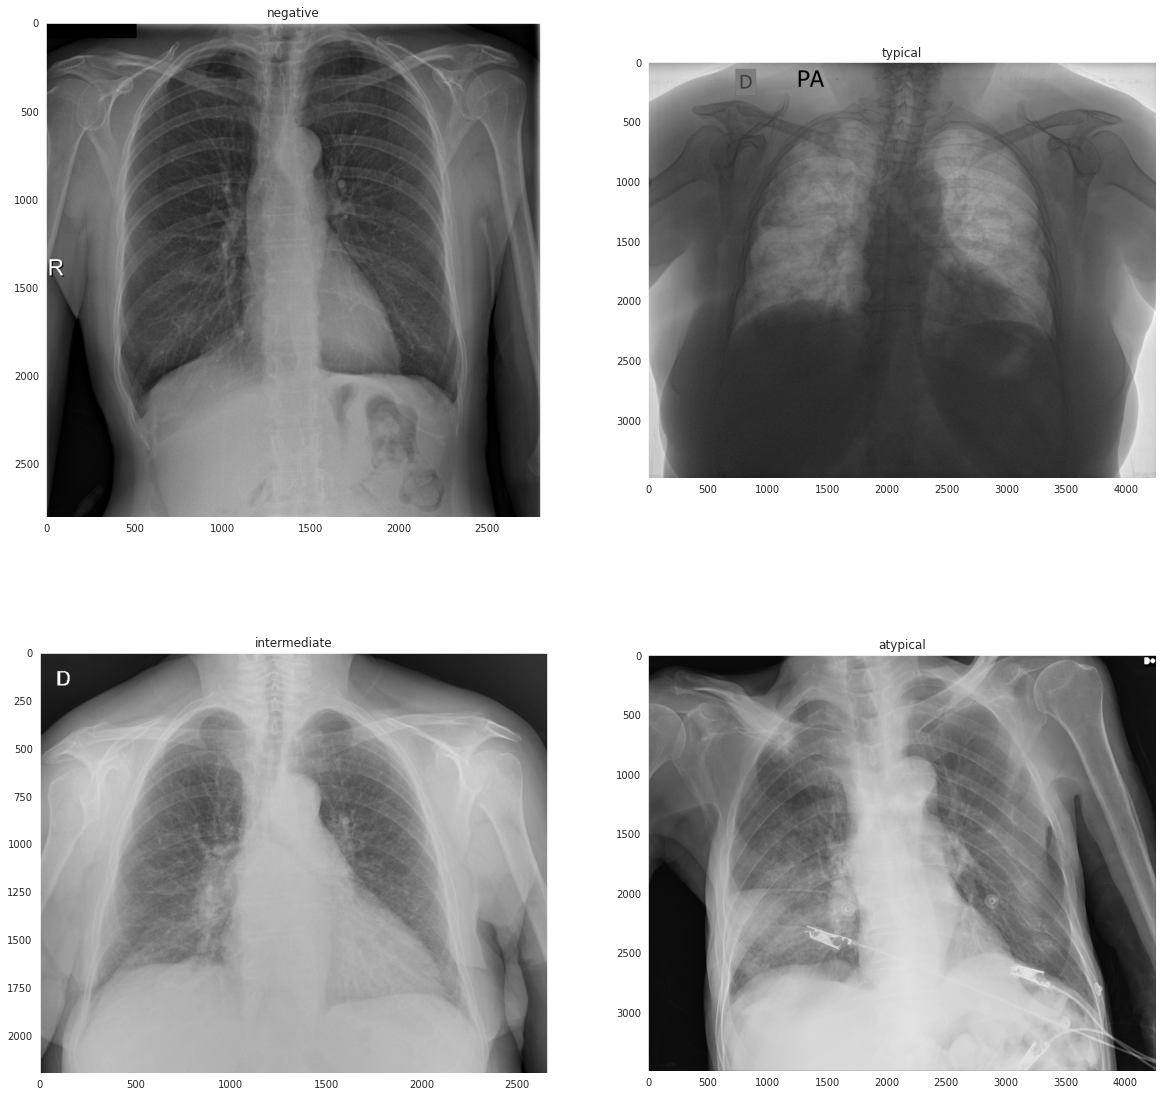

In [ ]:
random_display()

## Observations:
I am not a radiologist so I can't say anything but be mindful that the label is from the study and is not the label of the image itself. To repeat the label is from the study and not the image.

## Saving every image in jpg format
I previously though of creating a png based dataset from dicom files but I found one already created and I will use it for further development.